In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn as nn 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
from pathlib import Path

c:\Users\sanat\.conda\envs\ds\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mnist_dir = Path(os.getcwd()) / Path("MNIST/raw/")
dataset_dir = []
for dirs in os.listdir(mnist_dir):
    dataset_dir.append(mnist_dir / dirs)
    
images_dir = [dataset_dir[0], dataset_dir[2]]
labels_dir = [dataset_dir[1], dataset_dir[3]]
images_dir, labels_dir

([WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/t10k-images-idx3-ubyte.gz'),
  WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/train-images-idx3-ubyte.gz')],
 [WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/t10k-labels-idx1-ubyte.gz'),
  WindowsPath('d:/material/Machine_Deep/github_repos/AI_/AI/DL/Vision/Visualizing_CNN/MNIST/raw/train-labels-idx1-ubyte.gz')])

In [3]:
f = gzip.open(images_dir[0],'r')
metadata = f.read(16)

In [4]:
import struct

# Unpack the bytes into integers
magic_number = struct.unpack('>i', metadata[:4])[0]
num_images = struct.unpack('>i', metadata[4:8])[0]
num_rows = struct.unpack('>i', metadata[8:12])[0]
num_cols = struct.unpack('>i', metadata[12:16])[0]

# Print the values
print("Magic Number:", magic_number)
print("Number of Images:", num_images)
print("Number of Rows:", num_rows)
print("Number of Columns:", num_cols)


Magic Number: 2051
Number of Images: 10000
Number of Rows: 28
Number of Columns: 28


In [5]:
def extract_images(file_path, num_images = 60_000):

    f = gzip.open( file_path,'r')
    image_size = 28
    metadata = f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    return data

def extract_labels(file_path, num_labels = 60_000):

    f = gzip.open(file_path,'r')
    f.read(8)  
    buf = f.read(num_labels)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels


In [6]:
train_images = extract_images(images_dir[1], 60_000)
train_labels = extract_labels(labels_dir[1], 60_000)

test_images = extract_images(images_dir[0], 10_000)
test_labels = extract_labels(labels_dir[0], 10_000)


# Converting to torch
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels)

test_images = torch.from_numpy(test_images)
test_labels = torch.from_numpy(test_labels)

# Resizing according to PyTorch conventions
train_images = train_images.swapaxes(1, 3)
test_images = test_images.swapaxes(1, 3)

In [7]:
class CustomDataset(Dataset):
    def __init__(self,
                 dataset,
                 labels,
                 transform = None):
        
        self.images = dataset
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):

        image = self.images[index]
        if self.transform:
            image =  self.transform(self.images[index])
        
        return (image, self.labels[index])
    
    def __len__(self):
        return len(self.images)

## Making dataset and dataloader

In [8]:
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
train_dataset = CustomDataset(dataset=train_images,
                              labels=train_labels,
                              transform=train_transform)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


In [9]:
image = torch.ones((1, 3, 5, 5))
model = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=6,
              kernel_size=2,
              stride=1,
              padding=0)
)
print(model(image).shape)
torch.numel(model[0].weight) + torch.numel(model[0].bias)

torch.Size([1, 6, 4, 4])


78

In [10]:
image = torch.ones((1, 3, 5, 5))
model = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=6,
              kernel_size=2,
              stride=1,
              padding=0,
              groups=3)
)
print(model(image).shape)
torch.numel(model[0].weight) + torch.numel(model[0].bias)

torch.Size([1, 6, 4, 4])


30

In [11]:
class Classification(nn.Module):
    def __init__(self,
                 in_channels = 1):
        
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels * 2,
                      kernel_size=3,
                      stride=2,
                      padding=0,
                      groups=in_channels),
            nn.BatchNorm2d(num_features=in_channels * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=in_channels*2,
                      out_channels=in_channels * 4,
                      kernel_size=3,
                      stride=2,
                      padding=0,
                      groups=in_channels * 2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(144, 16),
            nn.Linear(16, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.block1(x)


In [12]:
model = Classification()
model(train_dataset[0][0].unsqueeze(0))

tensor([[0.1077, 0.1236, 0.0944, 0.0761, 0.0728, 0.1219, 0.1016, 0.0969, 0.1203,
         0.0848]], grad_fn=<SoftmaxBackward0>)

In [13]:
def train(model,
          dataloader,
          optimizer,
          epochs,
          loss_fn):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            predictios = model(images)
            loss = loss_fn(predictios, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 3 == 0:
            print(f"Loss -> {loss.item():.4f}")

            

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [15]:
train(model=model,
      dataloader=train_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10)

Loss -> 1.7208
Loss -> 1.6274
Loss -> 1.6404
Loss -> 1.6715


In [16]:
torch.argmax(model(train_dataset[200][0].unsqueeze(0)))

tensor(3)

In [17]:
train_dataset[200][1]

tensor(1)

# Visualizing the outputs

In [18]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [19]:
model

Classification(
  (block1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), groups=2)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=144, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=10, bias=True)
    (8): Softmax(dim=1)
  )
)

C:\Users\sanat\AppData\Local\Temp\ipykernel_19068\2742121894.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(model.block1[0].weight[0].detach().T)


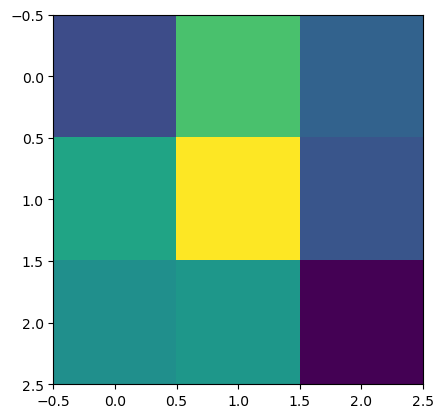

In [20]:
plt.imshow(model.block1[0].weight[0].detach().T)
plt.imshow(model.block1[0].weight[1].detach().T)

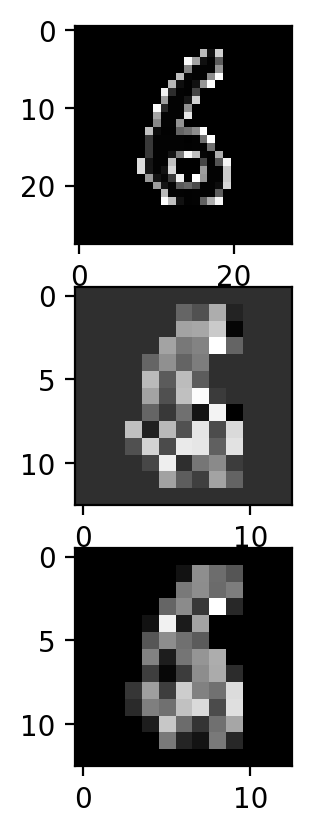

In [21]:
image = train_dataset[1020][0]

l1_f1 = model.block1[0](image)[0]
l1_f2 = model.block1[0](image)[1]

fig, axes = plt.subplots(nrows=3, dpi=200)

axes[0].imshow(image.T, cmap="gray")
axes[1].imshow(l1_f1.unsqueeze(0).T.detach().numpy(), cmap="gray")
axes[2].imshow(l1_f2.unsqueeze(0).T.detach().numpy(), cmap="gray")

In [22]:
model.block1[0], model.block1[0].weight.shape

(Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2)), torch.Size([2, 1, 3, 3]))

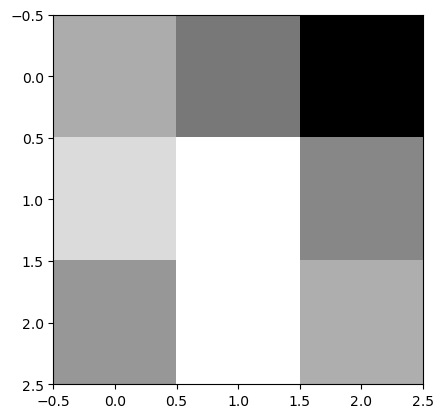

In [23]:
plt.imshow(model.block1[0].weight[0,:,:,:].reshape(3, 3).detach(), cmap="gray")

In [24]:
model.block1[0].weight[0,:,:,:]

tensor([[[ 0.1967,  0.0579, -0.2615],
         [ 0.3221,  0.4178,  0.0986],
         [ 0.1396,  0.4160,  0.2023]]], grad_fn=<SliceBackward0>)

## Visualizing for Another dataset Cifar

In [31]:
cifar_path = r"D:\material\Machine_Deep\github_repos\DL\resources\CNN_scratch\dataset"

In [46]:
def reshape_to_show(image: np.array):
    red_values = image[:1024].reshape(32, 32)
    green_values = image[1024: 1024+1024].reshape(32, 32)
    blue_values = image[1024+1024:].reshape(32, 32)
    
    image = np.dstack((red_values, green_values, blue_values))
    return image

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def extract_train_set(dataset_path):
    l = unpickle(dataset_path)
    xtrain = l[b'data']
    xtrain = np.array([reshape_to_show(image) for image in xtrain])
    ytrain = np.array(l[b'labels']).reshape(-1)
    return xtrain, ytrain

files_ = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
Xtrain1, ytrain1 = extract_train_set(cifar_path / Path(files_[0]))

train_set = {}
for a in range(len(files_)):
    temp = str(a)
    train_set[temp] = extract_images

import pickle

ytrain1 = np.array(l[b'labels']).reshape(-1)

with open(cifar_path / Path("batches.meta"), 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = np.array(class_names[b'label_names'])

print(f"Xtrain1 shape -> {Xtrain1.shape}")
print(f"ytrain1.shape -> {ytrain1.shape}")
print(f"class_names ->\n{class_names}")


Xtrain1 shape -> (10000, 32, 32, 3)
ytrain1.shape -> (10000,)
class_names ->
[b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']


In [36]:
l = dict()
l = unpickle(cifar_path / Path("test_batch"))

Xtest = l[b'data']
Xtest = np.array([reshape_to_show(image) for image in Xtest])

ytest = {}
ytest = np.array(l[b'labels']).reshape(-1)
print(f"Xtest shape -> {Xtest.shape}")
print(f"ytest.shape -> {ytest.shape}")

Xtest shape -> (10000, 32, 32, 3)
ytest.shape -> (10000,)


## Visualizing the images

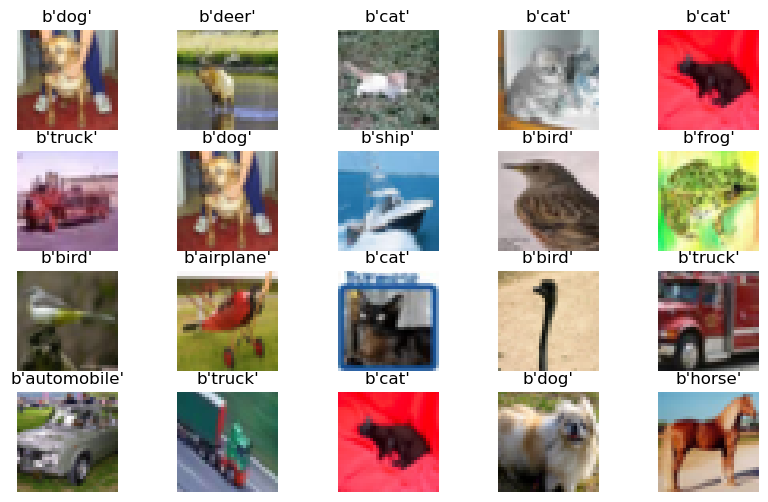

In [39]:
def plot_images(low, high, no_of_images = 30):
    '''
    Plots n random images
    n -> no_of_images
    NOTE: given n > 5
    '''
    cols = 5
    rows = int(no_of_images/cols)
    plt.figure(figsize=(10,6))
    for i in range(1, rows*cols+1):
        
        random_index = int(np.random.randint(low, high, 1))
        image = Xtrain1[random_index]
        plt.subplot(rows, cols, i)
        plt.imshow(image)
        plt.title(class_names[ytrain1[random_index]])
        plt.axis(False)        
    
plot_images(0,100, 20)

## Transforming the images..

In [41]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])

In [42]:
data_transform(Xtrain1[0]).shape, Xtrain1[0].shape, Xtrain1.shape, type(Xtrain1)

(torch.Size([3, 32, 32]), (32, 32, 3), (10000, 32, 32, 3), numpy.ndarray)